<a href="https://colab.research.google.com/github/AlexeyProvorov/chest-x-ray-diagnosis/blob/main/convnet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'chest-xray-pneumonia:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F17810%2F23812%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240709%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240709T130542Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1578aad9502fb5afa47a00c2d92fc3512c2ccc4dbff6651dfed508d57795b2f94fb760138b428034a7cc0f0028abb124fe865c2ed8b3ef3cb8b42af7431be3f3b5c36ec25ef20c9db995ce26c41bcbf27ff17f81a1906bbf3b723ce832e9536a6ab1dca0ec74120c27789f76bc696270f128a430ceb1e7fb4023f9b4d5a71ddfac682555c28418cd4f14dac24a033885b2600f2251d3aaa64945ca2f1defdb35f72a67ba06836c1b41b8e03e01f966efc7efe20ba74fb70eea89b82502fff5a3c7152f70310f864d1bc3ccf8526e8bddb095214e6481868b0e555b8ad075c0c3ad9c386e395226dd7cc3f01dfe1d36f74dbcd293efd603fb039b71888d5164fd'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2463365435 bytes downloaded
Downloaded and uncompressed: chest-xray-pneumonia
Data source import complete.


In [1]:
%%capture

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Importing all the libraries

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, random
import sklearn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, classification_report
from pathlib import Path
import cv2

import warnings
warnings.filterwarnings('ignore')

<a id="2"></a>
# **<span style="color:#6B614B;">LOADING DATA</span>**

In [ ]:
# Define path to the data directory
dir_alldata = Path('../input/chest-xray-pneumonia/chest_xray/chest_xray')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_data_dir = dir_alldata / 'train'

# Path to validation directory
validation_data_dir = dir_alldata / 'val'

# Path to test directory
test_data_dir = dir_alldata / 'test'

# Get the path to the normal and pneumonia sub-directories
normal_cases_train = train_data_dir / 'NORMAL'
pneumonia_cases_train = train_data_dir / 'PNEUMONIA'

In [ ]:
img_width, img_height = 150,150
nb_train_sample =1000
nb_validation_samples =100

epochs = 50
batch_size = 20

if K.image_data_format()=="channels_first":
    input_shape =(3,img_width, img_height)
else:
    input_shape =(img_width, img_height,3)

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)



train_generator= train_datagen.flow_from_directory(train_data_dir, target_size =(150,150),batch_size=batch_size, class_mode="binary" )

validation_generator = validation_datagen.flow_from_directory(validation_data_dir, target_size = (150,150),batch_size=batch_size, class_mode="binary")

test_generator = test_datagen.flow_from_directory(test_data_dir, target_size = (150,150),batch_size=batch_size, class_mode="binary")


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**<span style="color:#6B614B;">Three Random Normal CXR Images from the dataset</span>**

Printing three Normal random images 
NORMAL2-IM-0035-0001.jpeg
NORMAL2-IM-0033-0001.jpeg
NORMAL2-IM-0066-0001.jpeg


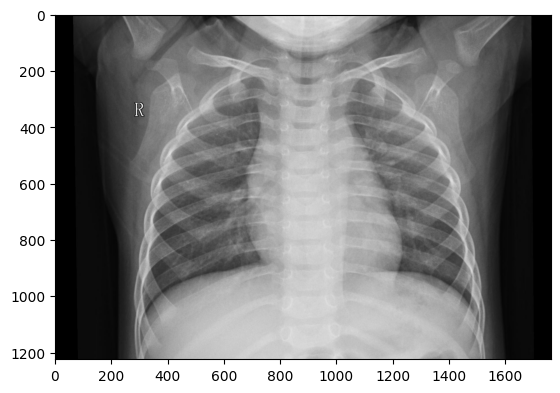

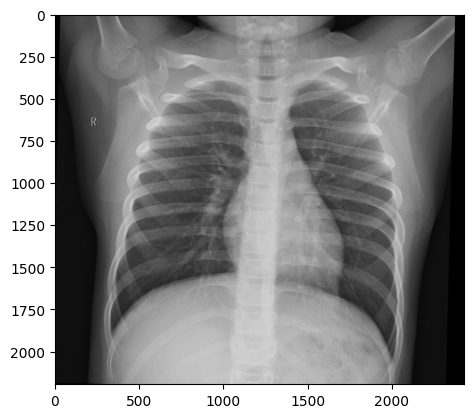

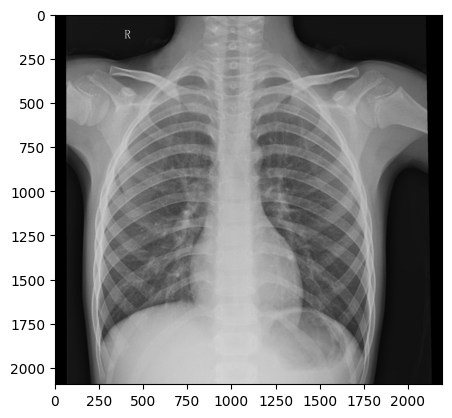

In [ ]:
# Three Random Normal CXR Images from the dataset
import os, random

folder_N=r"../input/chest-xray-pneumonia/chest_xray/test/NORMAL"

a=random.choice(os.listdir(folder_N))
b=random.choice(os.listdir(folder_N))
c=random.choice(os.listdir(folder_N))
print("Printing three Normal random images ")
print(a)
print(b)
print(c)

random_N = [a, b, c]

for i in random_N:
    file = folder_N+'/'+i
    img = image.load_img(file)
    plt.figure()
    plt.imshow(img)
    plt.show()


**<span style="color:#6B614B;">Three Random Pneumonia CXR Images from the dataset</span>**

Printing three PNEUMONIA random images 
person109_bacteria_523.jpeg
person128_bacteria_605.jpeg
person131_bacteria_629.jpeg


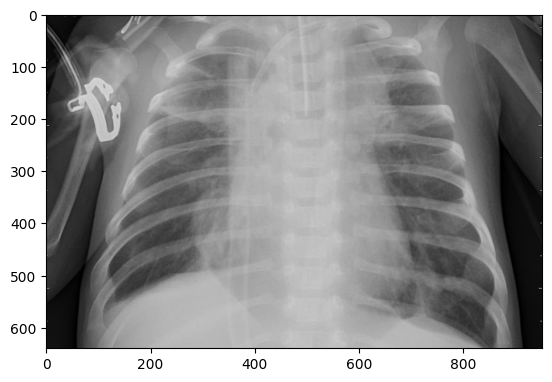

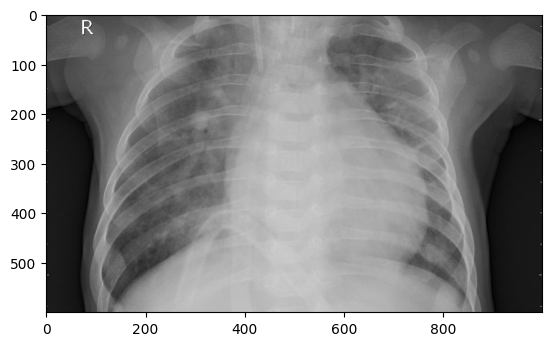

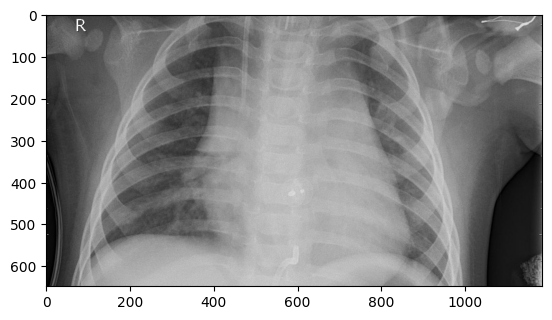

In [ ]:
# Three Random Pneumonia CXR Images from the dataset
import os, random

folder_P=r"../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA"

d=random.choice(os.listdir(folder_P))
e=random.choice(os.listdir(folder_P))
f=random.choice(os.listdir(folder_P))
print("Printing three PNEUMONIA random images ")
print(d)
print(e)
print(f)

random_P = [d, e, f]

for i in random_P:
    file = folder_P+'/'+i
    img = image.load_img(file)
    plt.figure()
    plt.imshow(img)
    plt.show()



The dataset is labelled by a medical professional. It is not decipherable for a layman. However, it seems like the sharpness around the diaphragm could be the deciding factor. Nonetheless, there have been exceptions in that case as well. So this diagnosis is a subjective matter.  Let's leave it to the Convnet to figure that out.

**Next, we will have a look at the count of classes.**

**<span style="color:#6B614B;">The count of classes</span>**

Text(0.5, 1.0, 'Count of Positive (0) and Negative Cases (1)')

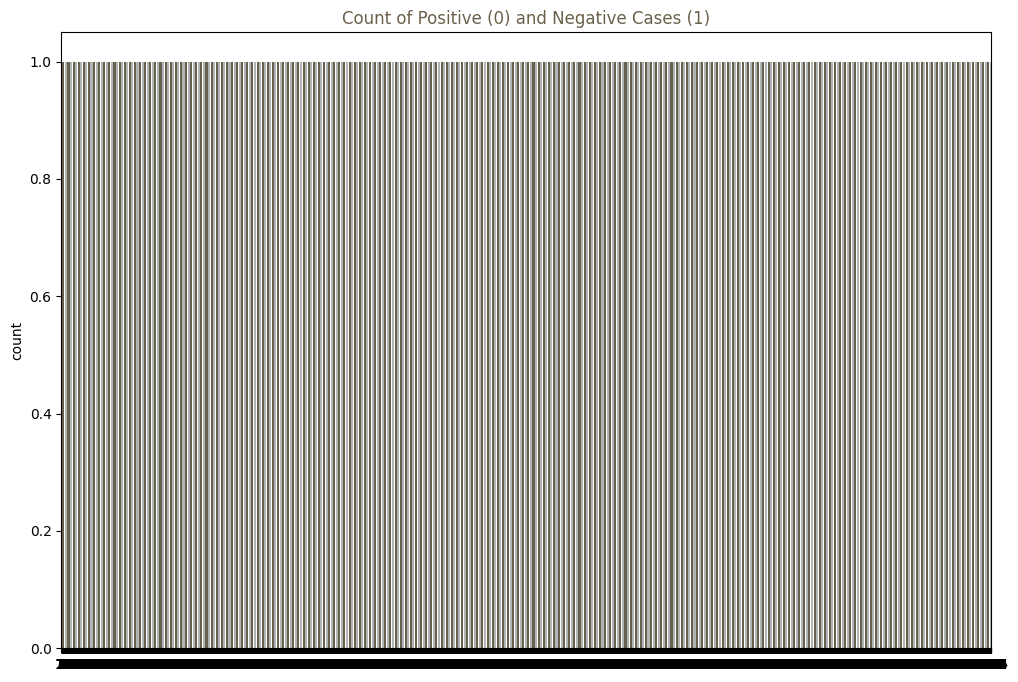

In [ ]:
# To plot the count plot I am changing the dataset into a pandas dataframe
# Get the list of all the images
normal = normal_cases_train.glob('*.jpeg')
pneumonia = pneumonia_cases_train.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_df = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal:
    train_df.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia:
    train_df.append((img,1))

# Get a pandas dataframe from the data we have in our list
train_df = pd.DataFrame(train_df, columns=['image', 'label'],index=None)

# Shuffle the data
train_df = train_df.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
plt.figure(figsize=(12,8))
count = sns.countplot(train_df["label"], palette=["#6B614B","#B0B7B5"])
count.set_title("Count of Positive (0) and Negative Cases (1)", color="#6B614B")


There is a data imbalance. The number of Pneumonia CXR images are more than the number of normal CXR images.  

<a id="4"></a>
# **<span style="color:#6B614B;">MODEL BUILDING</span>**


**In this project, we build an Convolutional neural network.**

Following steps are involved in the model building

* Initialising the Convnet
* Defining by adding layers
* Compiling the Convnet
* Train the Convnet

In [ ]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape=input_shape))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                   

In [ ]:
model.compile(loss= "binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=nb_train_sample//batch_size, epochs=epochs,validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size)

Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 0.6095 - accuracy: 0.7380

50/50 [==============================] - 45s 848ms/step - loss: 0.6095 - accuracy: 0.7380 - val_loss: 0.7793 - val_accuracy: 0.5000
Epoch 2/50
50/50 [==============================] - 43s 838ms/step - loss: 0.5416 - accuracy: 0.7350
Epoch 3/50
50/50 [==============================] - 42s 846ms/step - loss: 0.4211 - accuracy: 0.7932
Epoch 4/50
50/50 [==============================] - 43s 860ms/step - loss: 0.3564 - accuracy: 0.7990
Epoch 5/50
50/50 [==============================] - 43s 861ms/step - loss: 0.3416 - accuracy: 0.8230
Epoch 6/50
50/50 [==============================] - 43s 853ms/step - loss: 0.3356 - accuracy: 0.8660
Epoch 7/50
50/50 [==============================] - 43s 851ms/step - loss: 0.3628 - accuracy: 0.8420
Epoch 8/50
50/50 [==============================] - 46s 899ms/step - loss: 0.3168 - accuracy: 0.8550
Epoch 9/50
50/50 [==============================] - 43s 854ms/step - loss: 0.3016 - accuracy: 0.8830
Epoch 10/50
50/50 [==============================] - 42s 820

<a id="5"></a>
# **<span style="color:#6B614B;">CONCLUSION</span>**


**Concluding the model with:**

* Testing on the test set
* Evaluating Test Accuracy

In [ ]:
test_accuracy = model.evaluate_generator(test_generator)

In [ ]:
print('The accuracy on test set :',test_accuracy[1]*100 )

**<span style="color:#6B614B;"> If you liked this Notebook, please do upvote.</span>**

**<span style="color:#6B614B;"> If you have any suggestions or questions, feel free to comment!</span>**

**<span style="color:#6B614B;">Best Wishes!</span>**

<a id="6"></a>
<h1 style='background:#6B614B; border:0; color:#B0B7B5'><center>END</center></h1>